# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

There's also a cell that allows us to step through hyperparamters for any particular model to examine how the model overfits as a hyparameter changes.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you should select your final/best model and hyperparameters to run one time only and then make the business performance tables for that final model. Note once we've decided on the final model and hyperparameters we're allowed to make several trial runs of our final model train looking for a good performance on the testing data, as long as we don't make any changes to the model hyperparameters from our final choice.

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.2 MB/s eta 0:00:00


In [3]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import random
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# This will let you see all the particular library vertsions you have loaded
# %pip list

In [4]:
%%time
vars = pd.read_csv('vars_final.csv')
print(vars.shape)
vars.head()

(98037, 22)
CPU times: user 334 ms, sys: 25.8 ms, total: 360 ms
Wall time: 367 ms


,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14,...,Card_dow_unique_count_for_merch_zip_30,card_zip_count_1_by_60_sq,Card_dow_unique_count_for_Card_Merchdesc_30,Cardnum_count_0_by_60,card_state_count_1_by_30,card_state_total_amount_1_by_30,card_zip_total_amount_1_by_30,Cardnum_unique_count_for_card_zip_7,Recnum,Fraud
0,1.0,3.62,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0,...,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0,1,0.0
1,1.0,31.42,0.016667,31.42,0.016667,0.001111,0.000278,1.0,1.0,1.0,...,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0,2,0.0
2,1.0,178.49,0.016667,178.49,0.016667,0.001111,0.000278,1.0,1.0,1.0,...,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0,3,0.0
3,1.0,3.62,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0,...,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0,4,0.0
4,1.0,7.24,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0,...,1.0,0.000278,1.0,0.016667,0.033333,0.033333,0.033333,1.0,5,0.0


In [5]:
# set the number of variables desired here, and set the names of the y and record label properly
NVARS = 10

# vars.rename(columns={'record':'Recnum'},inplace=True)
# vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
detect_rate = .03
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])

final_vars_list

['Recnum',
 'Fraud',
 'Cardnum_unique_count_for_card_state_1',
 'card_state_total_3',
 'card_state_total_amount_1_by_60',
 'Cardnum_max_14',
 'card_zip_count_1_by_60',
 'card_state_count_1_by_30_sq',
 'Cardnum_count_0_by_60_sq',
 'Card_dow_unique_count_for_state_des_30',
 'Card_dow_unique_count_for_merch_state_14',
 'Card_dow_unique_count_for_merch_zip_14']

In [6]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14
0,1,0.0,1.0,3.62,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0
1,2,0.0,1.0,31.42,0.016667,31.42,0.016667,0.001111,0.000278,1.0,1.0,1.0
2,3,0.0,1.0,178.49,0.016667,178.49,0.016667,0.001111,0.000278,1.0,1.0,1.0
3,4,0.0,1.0,3.62,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0
4,5,0.0,1.0,7.24,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0


In [7]:
vars.shape

(98037, 12)

In [8]:
vars['Fraud'].sum()

np.float64(2492.0)

In [9]:
print("fraud rate in data is",(vars['Fraud'].sum()/len(vars)).round(4))

fraud rate in data is 0.0254


In [10]:
vars.head(10)

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14
0,1,0.0,1.0,3.62,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0
1,2,0.0,1.0,31.42,0.016667,31.42,0.016667,0.001111,0.000278,1.0,1.0,1.0
2,3,0.0,1.0,178.49,0.016667,178.49,0.016667,0.001111,0.000278,1.0,1.0,1.0
3,4,0.0,1.0,3.62,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0
4,5,0.0,1.0,7.24,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0
5,6,0.0,1.0,3.67,0.016667,3.67,0.016667,0.001111,0.000278,1.0,1.0,1.0
6,7,0.0,1.0,3.62,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0
7,8,0.0,1.0,230.32,0.016667,230.32,0.016667,0.001111,0.000278,1.0,1.0,1.0
8,9,0.0,1.0,62.11,0.016667,62.11,0.016667,0.001111,0.000278,1.0,1.0,1.0
9,10,0.0,1.0,10.86,0.016667,3.62,0.016667,0.001111,0.000278,1.0,1.0,1.0


In [11]:
vars.shape

(98037, 12)

In [12]:
vars.describe()

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14
count,98037.000000,98037.000000,98037.000000,98037.000000,9.803700e+04,98037.000000,98037.000000,98037.000000,9.803700e+04,98037.000000,98037.000000,98037.000000
mean,49185.587992,0.025419,1.757020,733.620037,8.024469e-03,1194.259716,0.011052,0.000654,4.180968e-05,3.449922,2.333221,2.335006
std,28418.418181,0.157395,1.643117,4087.096369,6.649885e-03,1852.307476,0.006105,0.000398,5.671510e-05,3.377390,2.316602,2.317518
min,1.000000,0.000000,1.000000,0.010000,1.901394e-07,0.140000,0.000030,0.000003,5.050505e-07,1.000000,1.000000,1.000000
25%,24564.000000,0.000000,1.000000,65.540000,1.552354e-03,309.020000,0.005556,0.000278,1.068376e-05,1.000000,1.000000,1.000000
50%,49186.000000,0.000000,1.000000,217.760000,5.961863e-03,804.930000,0.016667,0.000556,2.136752e-05,2.000000,2.000000,2.000000
75%,73808.000000,0.000000,2.000000,658.000000,1.666667e-02,1741.460000,0.016667,0.001111,4.629630e-05,4.000000,3.000000,3.000000
max,98393.000000,1.000000,21.000000,306633.410000,1.666667e-02,47900.000000,0.016667,0.001111,2.777778e-04,50.000000,41.000000,41.000000


In [13]:
# find the row i vars that corresponds to 11/1 for the OOT
test = vars[vars['Recnum'] > 85725]
test.head(10)

,Recnum,Fraud,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14
85396,85726,0.0,1.0,789.32,0.016667,609.34,0.016667,0.001111,0.000278,1.0,1.0,1.0
85397,85727,0.0,1.0,235.00,0.016667,399.15,0.016667,0.001111,0.000046,1.0,1.0,1.0
85398,85728,0.0,1.0,600.00,0.016667,600.00,0.016667,0.001111,0.000278,1.0,1.0,1.0
85399,85729,0.0,1.0,30.00,0.001265,30.00,0.008333,0.000556,0.000031,1.0,1.0,1.0
85400,85730,0.0,1.0,182.00,0.004183,1573.30,0.016667,0.000556,0.000008,3.0,2.0,2.0
85401,85731,0.0,1.0,174.61,0.007283,225.00,0.008333,0.000556,0.000139,1.0,1.0,1.0
85402,85732,0.0,1.0,259.90,0.000311,395.00,0.001515,0.000159,0.000010,2.0,3.0,3.0
85403,85733,0.0,1.0,25.00,0.000346,531.25,0.005556,0.000222,0.000019,3.0,3.0,3.0
85404,85734,0.0,1.0,97.17,0.000987,395.04,0.016667,0.000556,0.000019,1.0,1.0,1.0
85405,85735,0.0,1.0,6.51,0.003082,6.51,0.005556,0.000556,0.000093,1.0,1.0,1.0


In [14]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


## Scale and truncate field values

In [15]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14
count,98037.000000,98037.000000,9.803700e+04,98037.000000,98037.000000,98037.000000,9.803700e+04,98037.000000,98037.000000,98037.000000
mean,1.757020,733.620037,8.024469e-03,1194.259716,0.011052,0.000654,4.180968e-05,3.449922,2.333221,2.335006
std,1.643117,4087.096369,6.649885e-03,1852.307476,0.006105,0.000398,5.671510e-05,3.377390,2.316602,2.317518
min,1.000000,0.010000,1.901394e-07,0.140000,0.000030,0.000003,5.050505e-07,1.000000,1.000000,1.000000
25%,1.000000,65.540000,1.552354e-03,309.020000,0.005556,0.000278,1.068376e-05,1.000000,1.000000,1.000000
50%,1.000000,217.760000,5.961863e-03,804.930000,0.016667,0.000556,2.136752e-05,2.000000,2.000000,2.000000
75%,2.000000,658.000000,1.666667e-02,1741.460000,0.016667,0.001111,4.629630e-05,4.000000,3.000000,3.000000
max,21.000000,306633.410000,1.666667e-02,47900.000000,0.016667,0.001111,2.777778e-04,50.000000,41.000000,41.000000


In [16]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [17]:
# Outlier treatment: use this to limit variables. For some problems it helps
Clip = 10

In [18]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
X = (X - X.mean()) / X.std()
X.describe()

,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14
count,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04,9.803700e+04
mean,-5.740178e-17,7.827516e-18,4.406601e-17,-2.609172e-18,-2.783117e-17,9.277056e-18,8.697240e-19,1.971374e-17,2.551190e-17,-2.899080e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.624561e-01,-3.535511e-01,-1.206679e+00,-7.218116e-01,-1.805445e+00,-1.635089e+00,-7.282828e-01,-7.301471e-01,-5.910956e-01,-5.916135e-01
25%,-4.624561e-01,-3.196503e-01,-9.732673e-01,-5.323110e-01,-9.003706e-01,-9.442087e-01,-5.488119e-01,-7.301471e-01,-5.910956e-01,-5.916135e-01
50%,-4.624561e-01,-2.409018e-01,-3.101716e-01,-2.280658e-01,9.197603e-01,-2.467484e-01,-3.604359e-01,-4.318418e-01,-1.457875e-01,-1.465178e-01
75%,1.490252e-01,-1.315083e-02,1.299601e+00,3.465037e-01,9.197603e-01,1.148172e+00,7.910798e-02,1.647688e-01,2.995206e-01,2.985779e-01
max,1.004780e+01,2.116989e+01,1.299601e+00,1.137486e+01,9.197603e-01,1.148172e+00,4.160587e+00,1.007561e+01,1.031861e+01,1.031776e+01


In [19]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this OOT record number to whatever is appropriate for your data
oot_recnum = 85400
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]
Y_oot.sum()

,0
Fraud,356.0


## Look at PCA

In [20]:
len(X_trntst.columns)

10

In [21]:
X_trntst_save = X_trntst.copy()

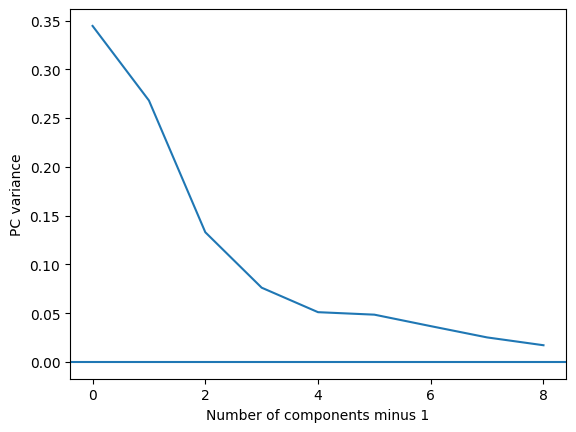

In [22]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [23]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 4, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4
0,-2.298592,2.828930,-1.044553,2.853312
1,-2.294038,2.831059,-1.023337,2.855314
2,-2.269947,2.842318,-0.911097,2.865906
3,-2.298592,2.828930,-1.044553,2.853312
4,-2.298448,2.829098,-1.043171,2.853872


In [24]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4
85400,-0.271263,-0.301918,0.152177,-0.789034
85401,-1.411576,-0.134906,-0.549871,1.599018
85402,0.354204,-2.270881,-0.356633,0.329590
85403,0.396363,-1.803357,-0.444931,0.211623
85404,-1.111503,-0.669822,-0.198713,-0.544822


In [25]:
X_trntst.describe()

,Cardnum_unique_count_for_card_state_1,card_state_total_3,card_state_total_amount_1_by_60,Cardnum_max_14,card_zip_count_1_by_60,card_state_count_1_by_30_sq,Cardnum_count_0_by_60_sq,Card_dow_unique_count_for_state_des_30,Card_dow_unique_count_for_merch_state_14,Card_dow_unique_count_for_merch_zip_14
count,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000,85400.000000
mean,0.005402,0.001902,-0.007191,0.003646,-0.016853,-0.016394,0.000793,0.018604,0.004191,0.004150
std,1.010079,1.015093,1.000565,0.986430,1.008559,1.003052,1.015169,1.025655,1.015940,1.015793
min,-0.462456,-0.353551,-1.206679,-0.721812,-1.805445,-1.635089,-0.728283,-0.730147,-0.591096,-0.591614
25%,-0.462456,-0.319930,-0.978909,-0.528642,-0.900371,-0.944209,-0.555789,-0.730147,-0.591096,-0.591614
50%,-0.462456,-0.241329,-0.325085,-0.219636,0.822253,-0.246748,-0.360436,-0.431842,-0.145788,-0.146518
75%,0.149025,-0.013151,1.299601,0.354197,0.919760,1.148172,0.079108,0.164769,0.299521,0.298578
max,10.047803,21.169890,1.299601,11.374863,0.919760,1.148172,4.160587,10.075611,10.318614,10.317765


In [26]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12637.000000,12637.000000,12637.000000,12637.000000
mean,-0.162351,0.136121,0.000288,-0.086914
std,1.661656,1.508477,1.103300,0.810441
min,-2.298898,-2.868975,-4.088040,-2.742315
25%,-1.155412,-1.110489,-0.429237,-0.622208
50%,-0.553779,-0.026500,-0.214440,-0.135327
75%,0.352563,1.480842,0.188719,0.283837
max,17.779793,7.010407,22.850611,6.264188


In [27]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [28]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4
count,8.540000e+04,85400.000000,8.540000e+04,8.540000e+04
mean,1.597473e-17,0.000000,3.328069e-18,-5.324910e-18
std,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
min,-1.226852e+00,-1.775766,-4.261524e+00,-3.258578e+00
25%,-5.685818e-01,-0.822654,-3.813573e-01,-6.515316e-01
50%,-2.173434e-01,-0.128616,-1.719380e-01,-5.239055e-02
75%,2.924765e-01,0.890179,1.811218e-01,4.049477e-01
max,1.149504e+01,4.654491,1.977602e+01,7.850799e+00


In [29]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4
count,12637.000000,12637.000000,12637.000000,12637.000000
mean,-0.086632,0.082347,0.000247,-0.098665
std,0.886675,0.912554,0.947611,0.920021
min,-1.226713,-1.735588,-3.511168,-3.113102
25%,-0.616539,-0.671791,-0.368667,-0.706336
50%,-0.295502,-0.016031,-0.184180,-0.153624
75%,0.188131,0.895836,0.162089,0.322214
max,9.487463,4.240950,19.626115,7.111166


In [30]:
X_trntst_pca.shape

(85400, 4)

In [31]:
X_oot_orig_pca.shape

(12637, 4)

## Subsample the larger class if desired

In [32]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.025011709601873537
(4219, 10) 4219


In [33]:
# We do a manual cross validation by running each model nitermax times for each choice of hyperparameters. The good
# statistical measurement of the model performance is the average across all these nitermax runs.
niter = 0
nitermax = 10
jittersize = .1
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and/or just explore one model type. You can also just rerun any single cell multiple times (hit shift-enter on that cell) as you "manually" explore different model hyperparameters.

In [34]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [35]:
%%time
# Logistic regression

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression()

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
    Modeling_output.iloc[counter] = ['log reg',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1

print(FDR.mean().round(3))
model_counter = model_counter + 1

0 0.658 0.642 0.542
1 0.655 0.651 0.539
2 0.648 0.663 0.539
3 0.646 0.67 0.534
4 0.654 0.638 0.539
5 0.646 0.67 0.545
6 0.657 0.632 0.534
7 0.653 0.653 0.542
8 0.653 0.654 0.542
9 0.657 0.647 0.542
trn    0.653
tst    0.652
oot    0.540
dtype: float64
CPU times: user 3.11 s, sys: 26.6 ms, total: 3.14 s
Wall time: 1.92 s


In [36]:
%%time
# Single DT

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(criterion='gini',
                                   splitter='random',
                                   max_depth = 12,
                                   min_samples_split=80,
                                   min_samples_leaf=40
                                  )

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
    Modeling_output.iloc[counter] = ['DT',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1

print(FDR.mean().round(3))
model_counter = model_counter + 1

0 0.678 0.647 0.525
1 0.688 0.64 0.537
2 0.672 0.661 0.539
3 0.677 0.671 0.542
4 0.681 0.66 0.553
5 0.675 0.676 0.559
6 0.671 0.641 0.548
7 0.682 0.653 0.57
8 0.686 0.678 0.545
9 0.678 0.654 0.528
trn    0.679
tst    0.658
oot    0.545
dtype: float64
CPU times: user 1.17 s, sys: 7.99 ms, total: 1.17 s
Wall time: 1.17 s


In [ ]:
# %%time
# # RF

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = RandomForestClassifier()
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['RF',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1

# print(FDR.mean().round(3))
# model_counter = model_counter + 1

In [70]:
%%time
# LGBM

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(boosting_type='gbdt',
                               num_leaves=100,
                               max_depth=3,
                               learning_rate=0.05,
                               n_estimators=100,
                              verbosity =-1)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
    Modeling_output.iloc[counter] = ['LGBM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1

print(FDR.mean().round(3))
model_counter = model_counter + 1

0 0.726 0.719 0.565
1 0.732 0.716 0.556
2 0.724 0.732 0.573
3 0.744 0.691 0.553
4 0.737 0.716 0.573
5 0.738 0.718 0.579
6 0.739 0.698 0.573
7 0.732 0.739 0.567
8 0.734 0.732 0.556
9 0.734 0.728 0.576
trn    0.734
tst    0.719
oot    0.567
dtype: float64
CPU times: user 9.88 s, sys: 19 ms, total: 9.9 s
Wall time: 9.95 s


In [ ]:
# %%time
# # LGBM with SMOTE
# from imblearn.over_sampling import SMOTE

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     sm = SMOTE()

#     X_trn_sm, Y_trn_sm = sm.fit_resample(X_trn,Y_trn)

#     print(niter, X_trn.shape,Y_trn.shape)
#     print(niter, X_trn_sm.shape,Y_trn_sm.shape)
#     print(Y_trn.sum())
#     print(Y_trn_sm.sum())

#     model = lgb.LGBMClassifier(boosting_type='gbdt',
#                                    num_leaves=100,
#                                    max_depth=3,
#                                    learning_rate=0.05,
#                                    n_estimators=100,
#                                     verbosity =-1)

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn_sm, Y_trn_sm.values.ravel())

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['LGBM with SMOTE',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1

# print(FDR.mean().round(3))
# model_counter = model_counter + 1

In [ ]:
# %%time
# # LGBM with jitter

# jittersize = .1
# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     print(niter, X_trn.shape,Y_trn.shape)

#     X_trn_bads = X_trn[Y_trn == 1]
#     Y_trn_bads = Y_trn[Y_trn == 1]

#     print(X_trn_bads.head())
#     for i in range(2):
#         X_trn_more = X_trn_bads*(1+jittersize*random.uniform(-1,1))
#         X_trn = X_trn.append(X_trn_more,ignore_index=True)
#         Y_trn = Y_trn.append(Y_trn_bads,ignore_index=True)

#     print(niter, X_trn.shape,Y_trn.shape)

#     model = lgb.LGBMClassifier()

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['LGBM with jitter',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1

# print(FDR.mean().round(3))
# model_counter = model_counter + 1

In [71]:
%%time
# NN

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = MLPClassifier(hidden_layer_sizes=(10,8,6,4,2),
                          activation='relu',
                          solver='adam',
                          alpha=0.001,
                          learning_rate='constant',
                          max_iter=150)
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
    Modeling_output.iloc[counter] = ['NN',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1

print(FDR.mean().round(3))
model_counter = model_counter + 1

0 0.698 0.66 0.584
1 0.031 0.024 0.059
2 0.717 0.703 0.584
3 0.712 0.725 0.545
4 0.711 0.695 0.612
5 0.721 0.692 0.57
6 0.026 0.03 0.02
7 0.695 0.714 0.565
8 0.697 0.704 0.573
9 0.7 0.683 0.556
trn    0.571
tst    0.563
oot    0.467
dtype: float64
CPU times: user 3min 5s, sys: 237 ms, total: 3min 6s
Wall time: 3min 5s


In [ ]:
# %%time
# # NN on pc's

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = MLPClassifier(hidden_layer_sizes=(1,1))

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['NN_PCs',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1

# print(FDR.mean().round(3))
# model_counter = model_counter + 1

In [ ]:
# %%time
# # GBC

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = GradientBoostingClassifier()

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['GBC',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1

# print(FDR.mean().round(3))
# model_counter = model_counter + 1

In [72]:
%%time
# Catboost

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = CatBoostClassifier(
                                iterations=1000,
                                learning_rate=0.005,
                                depth=8,
                                l2_leaf_reg=4,
                                border_count=150,
                                random_seed=42,
                                verbose=False
                            )

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
    Modeling_output.iloc[counter] = ['cat boost',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1

print(FDR.mean().round(3))
model_counter = model_counter + 1

0 0.79 0.72 0.596
1 0.779 0.721 0.59
2 0.776 0.725 0.596
3 0.781 0.773 0.593
4 0.786 0.745 0.59
5 0.783 0.744 0.598
6 0.776 0.74 0.59
7 0.778 0.743 0.593
8 0.781 0.719 0.601
9 0.779 0.725 0.601
trn    0.781
tst    0.736
oot    0.595
dtype: float64
CPU times: user 7min 34s, sys: 32.5 s, total: 8min 6s
Wall time: 4min 42s


In [ ]:
# %%time
# # NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set.
# # Only use this cell if you do downsampling of the goods.
# # each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# # it's hard to get the correct FDR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

# xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
# print(xmult)
# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)

#     model = lgb.LGBMClassifier()

#     model.fit(X_trn, Y_trn.values.ravel())

#     X_oot = X_oot_orig.copy()
#     X_trn = X_trntst.copy()
#     Y_trn = Y_trntst.copy()
#     X_tst = X_trntst.copy()
#     Y_tst = Y_trntst.copy()

#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trntst['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_trntst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['LGBM sampled',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1

# print(FDR.mean().round(3))
# model_counter = model_counter + 1

In [ ]:
# %%time
# # Catboost on pc's

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = CatBoostClassifier(verbose=0)

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['cat boost_PCs',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1

# print(FDR.mean().round(3))
# model_counter = model_counter + 1

In [ ]:
# %%time
# # unsupervised model using pc's.

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     pow = 2
#     oop = 1/pow
#     predictions = ((X_trn.abs()**pow).sum(axis=1))**oop
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = ((X_tst.abs()**pow).sum(axis=1))**oop
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = ((X_oot.abs()**pow).sum(axis=1))**oop
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['unsupervised outliers',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1

# print(FDR.mean().round(3))
# model_counter = model_counter + 1

In [73]:
%%time
# XGB

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = xgb.XGBClassifier(booster="gbtree",
                                learning_rate=0.05,
                                n_estimators=30,
                                max_depth=7,
                                gamma=5,
                                reg_lambda=5
                             )

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
    Modeling_output.iloc[counter] = ['XGB',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1

print(FDR.mean().round(3))
model_counter = model_counter + 1

0 0.74 0.743 0.528
1 0.757 0.716 0.576
2 0.746 0.739 0.559
3 0.757 0.716 0.584
4 0.745 0.728 0.576
5 0.75 0.745 0.573
6 0.747 0.737 0.576
7 0.749 0.732 0.559
8 0.753 0.71 0.565
9 0.752 0.717 0.567
trn    0.750
tst    0.728
oot    0.566
dtype: float64
CPU times: user 7.33 s, sys: 38.5 ms, total: 7.36 s
Wall time: 4.59 s


In [74]:
%%time
# Knn
# Knn can be very slow with a lot of records.

FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
    model = KNeighborsClassifier(n_neighbors=12)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*detect_rate))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*detect_rate))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*detect_rate))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
    Modeling_output.iloc[counter] = ['Knn',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
    counter = counter + 1

print(FDR.mean().round(3))
model_counter = model_counter + 1

0 0.759 0.742 0.576
1 0.769 0.721 0.579
2 0.767 0.709 0.598
3 0.766 0.728 0.587
4 0.769 0.723 0.565
5 0.774 0.723 0.559
6 0.77 0.728 0.579
7 0.765 0.726 0.573
8 0.768 0.716 0.584
9 0.773 0.693 0.562
trn    0.768
tst    0.721
oot    0.576
dtype: float64
CPU times: user 2min 53s, sys: 194 ms, total: 2min 54s
Wall time: 2min 54s


In [ ]:
# %%time
# # SVM
# # SVM can be very slow. It scales like the # training records cubed

# FDR = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = svm.SVC(kernel='poly',probability=True)

#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*detect_rate))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*detect_rate))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*detect_rate))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR.loc[niter, 'trn'].round(3),FDR.loc[niter, 'tst'].round(3),FDR.loc[niter, 'oot'].round(3))
#     Modeling_output.iloc[counter] = ['SVM',FDR.loc[niter, 'trn'],FDR.loc[niter, 'tst'],FDR.loc[niter, 'oot']]
#     counter = counter + 1

# print(FDR.mean().round(3))
# model_counter = model_counter + 1

## Model comparison plots

In [75]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,log reg,0.657948,0.64186,0.542135
1,log reg,0.65536,0.651057,0.539326
2,log reg,0.647907,0.662739,0.539326
3,log reg,0.645749,0.669725,0.533708
4,log reg,0.653899,0.637982,0.539326
5,log reg,0.646123,0.669856,0.544944
6,log reg,0.657365,0.631933,0.533708
7,log reg,0.653089,0.653092,0.542135
8,log reg,0.652659,0.65416,0.542135
9,log reg,0.656824,0.647059,0.542135


In [76]:
df.shape

(70, 4)

In [77]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], \
                     var_name='Type', value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.657948
1,log reg,Trn,0.65536
2,log reg,Trn,0.647907
3,log reg,Trn,0.645749
4,log reg,Trn,0.653899


In [78]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,log reg,Trn,0.657948
1,log reg,Trn,0.65536
2,log reg,Trn,0.647907
3,log reg,Trn,0.645749
4,log reg,Trn,0.653899


In [79]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
               mean       std      mean       std      mean       std
Model                                                                
DT         0.678935  0.005528  0.658258  0.013759  0.544663  0.013726
Knn        0.767948  0.004337  0.721028  0.013112  0.576124  0.012169
LGBM       0.734156  0.005929  0.718955  0.015330  0.567135  0.009121
NN         0.570735  0.285889  0.563043  0.283072  0.466854  0.226242
XGB        0.749631  0.005324  0.728356  0.012619  0.566292  0.015679
cat boost  0.780922  0.004236  0.735504  0.017077  0.594663  0.004402
log reg    0.652692  0.004589  0.651946  0.012830  0.539888  0.003698

In [80]:
df.head()

,Model,Trn,Tst,OOT
0,log reg,0.657948,0.64186,0.542135
1,log reg,0.65536,0.651057,0.539326
2,log reg,0.647907,0.662739,0.539326
3,log reg,0.645749,0.669725,0.533708
4,log reg,0.653899,0.637982,0.539326


In [81]:
best_OOT = df['OOT'].max()
best_OOT

np.float64(0.6123595505617978)

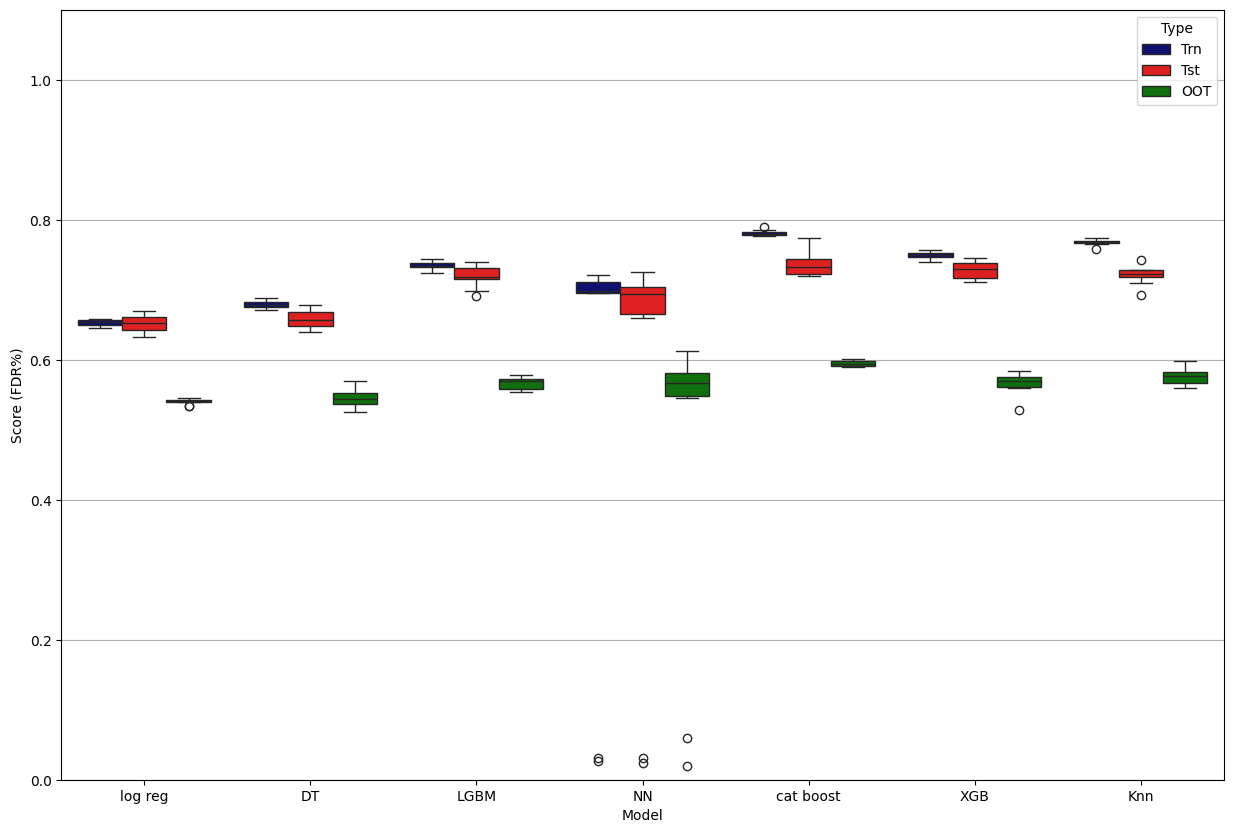

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(0.,1.1)
plt.ylabel('Score (FDR%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [ ]:
print('duration: ', datetime.now() - start_time)

duration:  0:05:25.734838


This next cell is used to explore overfitting

In [41]:
%%time
nitermax2 = 3 # let's reduce the number of runs to make it faster
training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in range(1,14,1):
    for niter in range(nitermax2):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

        model = DecisionTreeClassifier(max_depth=i)

        model.fit(X_trn, Y_trn.values.ravel())

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()

        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*detect_rate))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*detect_rate))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*detect_rate))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

0 0.42827298050139273 0.4542857142857143 0.3455056179775281
1 0.44459190444591906 0.41017488076311603 0.3455056179775281
2 0.4299255247122546 0.44157814871016693 0.3455056179775281
loop trn tst oot 1 0.43426346988652215 0.43534624791966575 0.34550561797752816
0 0.5413584398117014 0.5500770416024653 0.42696629213483145
1 0.5906945380984491 0.5773353751914242 0.47191011235955055
2 0.5838751625487646 0.5852842809364549 0.4691011235955056
loop trn tst oot 2 0.5719760468196383 0.5708988992434482 0.4559925093632959
0 0.6225654801880457 0.6197836166924265 0.5056179775280899
1 0.6127744510978044 0.6461295418641391 0.5056179775280899
2 0.6299003322259136 0.606973058637084 0.5056179775280899
loop trn tst oot 3 0.6217467545039211 0.6242954057312166 0.5056179775280899
0 0.6386271870794078 0.5984615384615385 0.47752808988764045
1 0.6414715719063545 0.6302652106084243 0.5
2 0.6344370860927152 0.5926517571884984 0.4606741573033708
loop trn tst oot 4 0.6381786150261592 0.6071261687528204 0.47940074906

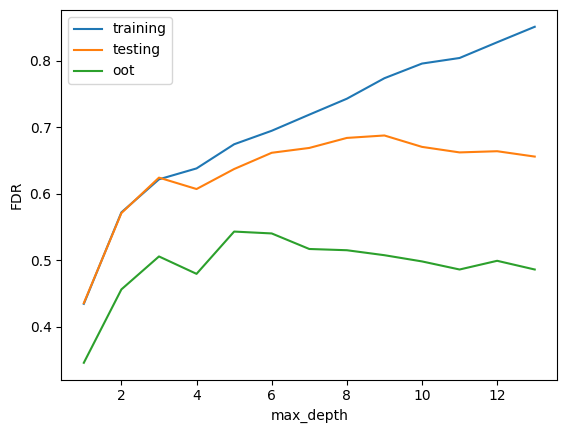

In [42]:
table=pd.DataFrame({'n': range(1,14,1),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True)
ax = table.plot(xlabel = "max_depth", ylabel = "FDR")
plt.savefig('complexity_NN.png', format='png')
plt.show()

In [ ]:
%%time
nitermax2 = 3 # let's reduce the number of runs to make it faster
training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in range(201,0,-10):
    for niter in range(nitermax2):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

        model = xgb.XGBClassifier(min_child_weight = i)

        model.fit(X_trn, Y_trn.values.ravel())

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()

        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*detect_rate))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*detect_rate))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*detect_rate))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

0 0.6862091938707529 0.6787401574803149 0.5280898876404494
1 0.692154255319149 0.6566455696202531 0.5168539325842697
2 0.7000663570006636 0.6454689984101749 0.5337078651685393
loop trn tst oot 201 0.6928099353968552 0.660284908503581 0.5262172284644194
0 0.6868754163890739 0.6929133858267716 0.5280898876404494
1 0.6763513513513514 0.6951219512195121 0.5280898876404494
2 0.6872536136662286 0.7296416938110749 0.5308988764044944
loop trn tst oot 191 0.6834934604688847 0.7058923436191195 0.5290262172284644
0 0.6954760297096556 0.7099236641221374 0.5533707865168539
1 0.6970310391363023 0.7033639143730887 0.5308988764044944
2 0.6915322580645161 0.6975308641975309 0.5393258426966292
loop trn tst oot 181 0.6946797756368247 0.7036061475642522 0.5411985018726592
0 0.6987951807228916 0.7009345794392523 0.5421348314606742
1 0.6949035812672176 0.7032163742690059 0.5308988764044944
2 0.7031778228532792 0.6971080669710806 0.5449438202247191
loop trn tst oot 171 0.698958861614463 0.7004196735597796 0.

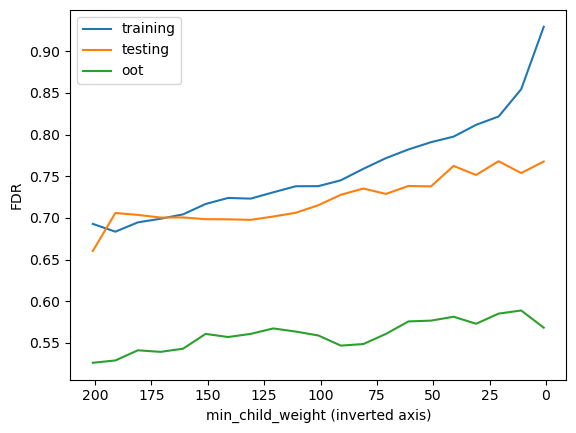

In [ ]:
table=pd.DataFrame({'n': range(201,0,-10),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True)
ax = table.plot(xlabel = "min_child_weight (inverted axis)", ylabel = "FDR")
ax.invert_xaxis()
plt.savefig('complexity_XGB.png', format='png')
plt.show()

In [68]:
%%time
nitermax2 = 3 # let's reduce the number of runs to make it faster
training = []
testing = []
oot = []
results = pd.DataFrame(np.zeros((niter,3)),columns=['trn','tst','oot'])
for i in range(1,42,4):
    for niter in range(nitermax2):
        X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

        model = lgb.LGBMClassifier(
            num_leaves=2*i,
            max_depth=i,
            n_estimators=100,         # Example: High number of estimators
            learning_rate=0.2,        # Example: Higher learning rate
            min_child_samples=5,      # Example: Lower value
            lambda_l1=0,              # Example: No L1 regularization
            lambda_l2=0,              # Example: No L2 regularization
            random_state=42,
            min_split_gain = 0, # Vary random state for runs
            verbosity=-1
        )

        model.fit(X_trn, Y_trn.values.ravel())

        X_oot = X_oot_orig.copy()
        X_trn_save = X_trn.copy()
        Y_trn_save = Y_trn.copy()

        predictions = model.predict_proba(X_trn_save)[:,1]
        X_trn['predicted'] = predictions
        X_trn['Fraud'] = Y_trn_save['Fraud']
        topRows = int(round(X_trn.shape[0]*detect_rate))
        temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

        predictions = model.predict_proba(X_tst)[:,1]
        X_tst['predicted']=predictions
        X_tst['Fraud'] = Y_tst['Fraud']
        topRows = int(round(X_tst.shape[0]*detect_rate))
        temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

        predictions = model.predict_proba(X_oot)[:,1]
        X_oot['predicted']=predictions
        X_oot['Fraud'] = Y_oot['Fraud']
        topRows = int(round(X_oot.shape[0]*detect_rate))
        temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
        needed = temp.loc[:,'Fraud']
        results.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
        # print(niter, results.loc[niter,'trn'],results.loc[niter,'tst'],results.loc[niter,'oot'],)

    results_mean_trn = results['trn'].mean()
    results_mean_tst = results['tst'].mean()
    results_mean_oot = results['oot'].mean()
    print('loop', 'trn', 'tst', 'oot', i, results_mean_trn, results_mean_tst, results_mean_oot)
    training.append(results_mean_trn)
    testing.append(results_mean_tst)
    oot.append(results_mean_oot)

loop trn tst oot 1 0.6549816317721516 0.6630042475327244 0.5271535580524346
loop trn tst oot 5 0.7933292406364129 0.7345710130589841 0.551498127340824
loop trn tst oot 9 0.876485528231524 0.6962022618492242 0.5280898876404494
loop trn tst oot 13 0.9037308703009529 0.6670581420432522 0.48595505617977536
loop trn tst oot 17 0.9471432018170748 0.6931295502652879 0.5084269662921348
loop trn tst oot 21 0.9849841322848488 0.6765077058812751 0.4794007490636704
loop trn tst oot 25 0.9767657061080076 0.6572637141542038 0.47752808988764045
loop trn tst oot 29 0.9767411024689437 0.6646328884241206 0.45692883895131087
loop trn tst oot 33 0.9823871993648181 0.6911789771492787 0.5215355805243446
loop trn tst oot 37 0.9835040428018792 0.6987093795577013 0.50187265917603
loop trn tst oot 41 0.9807745103168687 0.6944579226778065 0.5084269662921349
CPU times: user 51.2 s, sys: 223 ms, total: 51.4 s
Wall time: 51.7 s


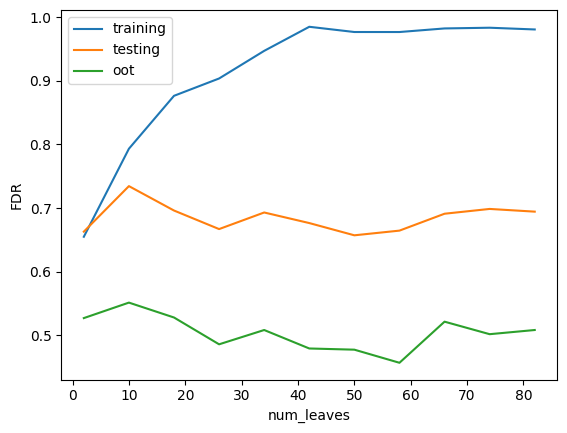

In [69]:
table=pd.DataFrame({'n': range(2,85,8),'training':training,'testing':testing,'oot':oot})
table.set_index('n',inplace=True)
ax = table.plot(xlabel = "num_leaves", ylabel = "FDR")
plt.savefig('complexity_XGB.png', format='png')
plt.show()

In [ ]:
best_OOT

0.6067415730337079

We will create a separate notebook which will utilize the final model of choice and build necessary tables for reporting.